# Random Forest Forecasting

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
# Correct import for skforecast v0.16
from skforecast.recursive import ForecasterRecursive

## Load The Train and Test Daily Delhi Climate data

In [4]:
# Step 1: Load and prepare data
train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])


## Do Some Feature Engineering

In [5]:
train = train[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})
test = test[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})

train.set_index('ds', inplace=True)
test.set_index('ds', inplace=True)
train = train.asfreq('D')
test = test.asfreq('D')

## Create and Fit the Model

In [6]:
# Step 2: Create and fit Random Forest forecaster
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
forecaster = ForecasterRecursive(regressor=regressor, lags=180)

## Compute Prediction Interval

In [7]:

# 1) Choose a calibration window from the tail of train
alpha = 0.05  # 95% PI
cal_size = max(60, int(0.2 * len(train)))  # 20% of train (>=60 pts); adjust as you like

y_train_main = train['y'].iloc[:-cal_size]
y_cal        = train['y'].iloc[-cal_size:]

# 2) Fit on the main part of train, forecast over the calibration span
forecaster.fit(y=y_train_main)
yhat_cal = forecaster.predict(steps=len(y_cal))
yhat_cal = yhat_cal.reindex(y_cal.index)   # ensure perfect alignment

# 3) Compute residual quantiles from calibration
resid_cal = (y_cal - yhat_cal).values
q_low = np.quantile(resid_cal, alpha/2)          # e.g., 2.5th percentile
q_high = np.quantile(resid_cal, 1 - alpha/2)     # e.g., 97.5th percentile

# 4) Refit on full train and forecast test
forecaster.fit(y=train['y'])
n_steps = len(test)
predictions = forecaster.predict(steps=n_steps)
predictions = predictions.reindex(test.index)

# 5) Fast conformal PI for the test forecast (shift by residual quantiles)
pi_lower = predictions + q_low
pi_upper = predictions + q_high


## Plot Actual Test Data, Predicted Test Data, and Precision Interval

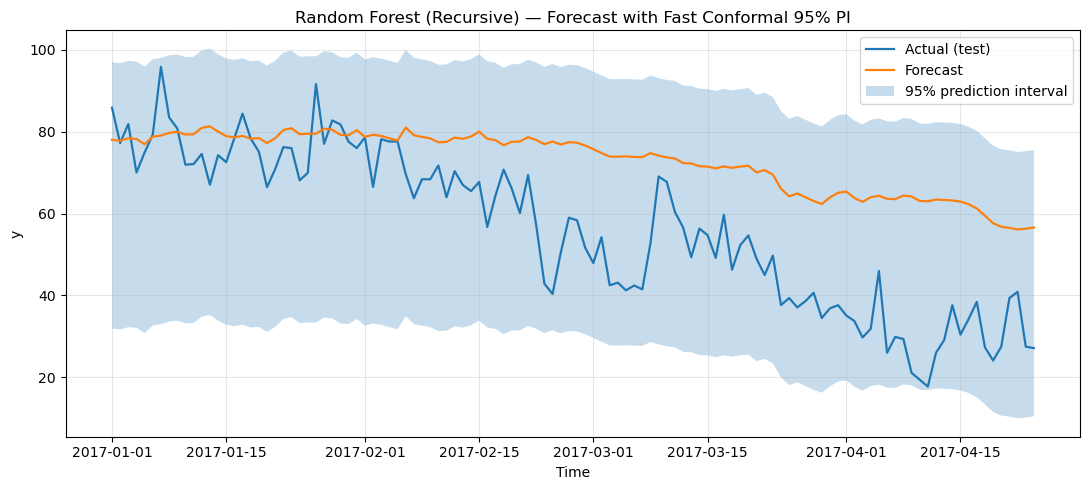

In [8]:


# --- Plot: actual test, forecast, and PI ---
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(test.index, test['y'].values, label='Actual (test)', linewidth=1.6)
ax.plot(predictions.index, predictions.values, label='Forecast', linewidth=1.6)
ax.fill_between(predictions.index, pi_lower.values, pi_upper.values, alpha=0.25,
                label=f'{int((1-alpha)*100)}% prediction interval')

ax.set_title('Random Forest (Recursive) — Forecast with Fast Conformal 95% PI')
ax.set_xlabel('Time'); ax.set_ylabel('y'); ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); 
plt.savefig("RandomForestForecastPLOT.png")
plt.show()



## Compute Errors And Coverage of Prediction Interval

In [9]:
from sklearn.metrics import mean_absolute_error

y_pred = predictions.reindex(test['y'].index)
#MSE
mse = mean_squared_error(test['y'], y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test['y'],y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# --- Interval coverage on the test set ---
coverage = ((test['y'] >= pi_lower) & (test['y'] <= pi_upper)).mean()
print(f'Prediction interval coverage: {coverage:.2%}')


Test MSE:  448.7754
Test RMSE: 21.1843
Test MAE:  17.6010
Prediction interval coverage: 100.00%


## Estimate Feature Importance

    Lag  Importance
0     1    0.779033
4     5    0.006761
37   38    0.004162
5     6    0.003071
16   17    0.002658
..  ...         ...
36   37    0.000605
49   50    0.000575
80   81    0.000541
78   79    0.000495
69   70    0.000450

[180 rows x 2 columns]


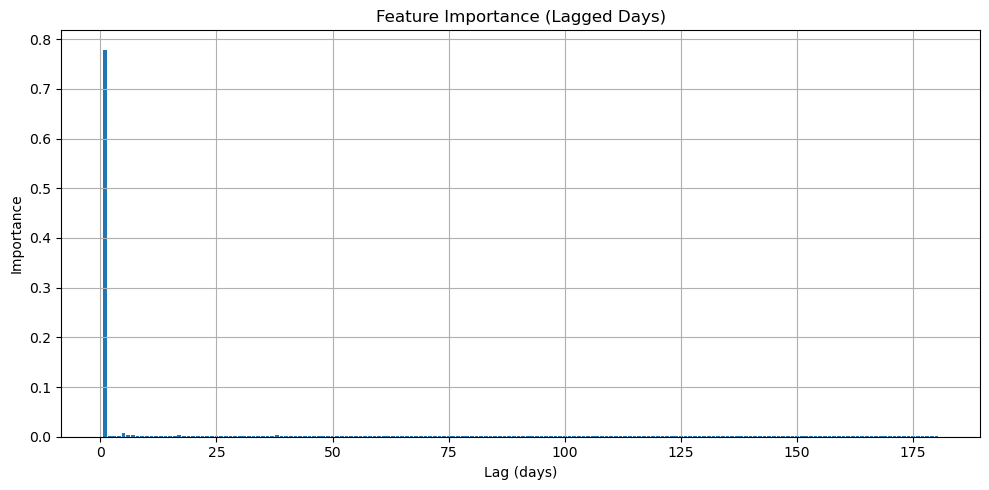

In [10]:
import numpy as np

# Get importance from trained regressor
importances = forecaster.regressor.feature_importances_
lags = forecaster.lags

# Create a sorted DataFrame
importance_df = pd.DataFrame({
    'Lag': lags,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Optional: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(importance_df['Lag'], importance_df['Importance'])
plt.title('Feature Importance (Lagged Days)')
plt.xlabel('Lag (days)')
plt.ylabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.savefig("LagImportancePLOT.png")
plt.show()